In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from tensorflow import keras 
import random
import shap
random.seed(1234)

/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/

In [2]:
# Our data is a fairly simple linear Model which is binarized for the Neural Net (second example)

xsize = 1000
X = np.random.rand(xsize,10)
# only X[:,0], X[:,4], X[:,1] and X[:,2] are relevant and their relevance is in that order
y = 5.*X[:,0] - 1. * X[:,1] - 0.5*X[:,2] - 4.*X[:,4] + 0.2*np.random.normal(size=xsize) 
yNN = (y> np.mean(y))*1



In [3]:
print(X[1,:])
print(y[1])

[0.57587524 0.56480405 0.6171897  0.91577584 0.87570756 0.9586376
 0.56066034 0.65012475 0.76804022 0.02647688]
-1.2938901938360623


In [4]:
reg = LinearRegression().fit(X,y)

In [5]:
print(reg.coef_)  # Seems alright!

[ 5.03210046e+00 -1.00166615e+00 -4.82469916e-01  1.88041036e-02
 -3.99680430e+00 -4.57412719e-03  9.57479982e-04 -1.09429971e-02
  2.18354439e-02  4.46516136e-02]


## Let's try to code SHAP for ourselves

In [6]:
p = X.shape[1] # Number of Features
n = 100 # Sample size

We wish to sample from an extreme Beta-Distribution so that we get either very few or very many features. The first case shows the isolatd effect of a feature, the latter the interaction of a feature with all other ones.

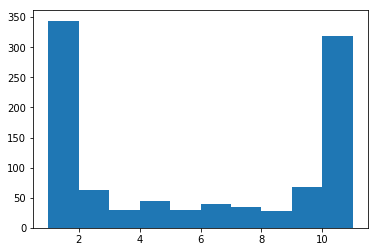

In [7]:
sample = np.random.beta(0.2, 0.2,1000)
sample = sample*X.shape[1]+1
sample = np.floor(sample).astype(int)
plt.hist(sample)
plt.show()

In [8]:
sel = np.random.choice(np.arange(p), size=3, replace=False)
print(sel)
r = np.arange(X.shape[1])
print(r[sel])
r[sel] = X.shape[1]
print(r)


[3 0 7]
[3 0 7]
[10  1  2 10  4  5  6 10  8  9]


In [9]:
def ChooseK(P):# P is integer of Feature number
    K =np.random.beta(0.2, 0.2,1)
    K = int(P*K+1)
    if K==P+1: # some degenerate cases
        K = K-1
    return(K)

In [10]:
ChooseK(X.shape[1])

1

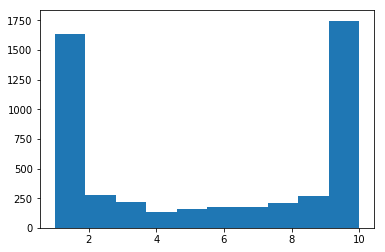

1.0 10.0
[ 6.  1.  1. ...  1. 10. 10.]


In [11]:
ks = np.empty(5000)
for ll in range(5000):
    ks[ll] =ChooseK(X.shape[1])
plt.hist(ks)
plt.show()
print(min(ks),max(ks))
print(ks)

In [12]:
def SwapFeatures(i,m,j,k):
    # take instance x_i, exchange k of its features randomly with the features of x_m including the jth Feature
    output = X[i,:].copy()
    
    if k == 1: # only change jth Feature
        output[j] = X[m,j].copy()
    
    else:
        Selection = np.random.choice(np.arange(X.shape[1]), size=k, replace=False)
        while (np.sum(Selection==j) ==0): # Make sure that j is included in selection
            Selection = np.random.choice(np.arange(X.shape[1]), size=k, replace=False)
        
        output[Selection] = X[m,Selection].copy()
    
    return(output)
        
        

In [13]:
print(X[np.arange(4),:])
print(SwapFeatures(2,3,0,2)) # the instance X[2,:] gets 2 features from X[3,:], including X[:,0]

[[0.6548584  0.62452711 0.05623634 0.64520465 0.76198791 0.50511374
  0.62436509 0.15458074 0.77137547 0.50833434]
 [0.57587524 0.56480405 0.6171897  0.91577584 0.87570756 0.9586376
  0.56066034 0.65012475 0.76804022 0.02647688]
 [0.56441316 0.53510248 0.4902244  0.82769487 0.02714765 0.49926048
  0.56489094 0.66447874 0.87025362 0.42430187]
 [0.26356092 0.91702752 0.90971355 0.43094405 0.31963381 0.11386571
  0.64526955 0.48146997 0.22782705 0.75028685]]
[0.26356092 0.53510248 0.4902244  0.82769487 0.31963381 0.49926048
 0.56489094 0.66447874 0.87025362 0.42430187]


In [14]:
def Compare(x_j, x_noj, Model):
    return(Model.predict(x_j.reshape(1, -1)) - Model.predict(x_noj.reshape(1, -1)))

In [15]:
reg.predict(np.arange(X.shape[1]).reshape(1, -1))

array([-17.47943852])

In [16]:
def CalcShap(X,i,j,M,Model):
    # Calculate Shap values for DataSet X for ith instance and jth feature with M iterations for AI-Model "Model"
    M_iter = 0 # iteration index
    SHAPValues = np.empty(M)
    
    while M_iter<M:
        m = np.random.randint(X.shape[0]) # random instance to "mix" x_i with
    
        if m!=i:
            k = ChooseK(X.shape[1])
            
            x_dummy_noj = SwapFeatures(i,m,j,k) # sample from random other instance
            x_dummy_j = x_dummy_noj.copy()
            x_dummy_j[j] = X[i,j].copy()  # compare with j and without j
        
            SHAPValues[M_iter] = Compare(x_dummy_j,x_dummy_noj, Model=reg)
        
            M_iter = M_iter+1
            
    return(np.mean(SHAPValues))


In [17]:
def FeatureImportance(X,j,M1,M2,Model):
    # Calculate Feature Importancec over M1 instances for j'th Feature of Data Set X,
    #   compare each instance M2 times and evaluate via Model
    
    Output = np.empty(M1)
    
    for m1 in range(M1):
        i = np.random.randint(X.shape[0])
        Output[m1] = np.abs(CalcShap(X,i,j,M2,Model))
        
    return(np.mean(Output))
        

In [18]:
# Just for the ith instance
SHAPValues_i = np.empty(X.shape[1])
for index in range(X.shape[1]):
    SHAPValues_i[index] = CalcShap(X, i=0, j = index, M = 1000, Model=reg)

In [19]:
# For the entire Data Set
SHAP_Importance = np.empty(X.shape[1])
for Jf in range(X.shape[1]):
    SHAP_Importance[Jf] = FeatureImportance(X,Jf,100,100,reg)
    print(Jf, SHAP_Importance[Jf])

0 1.3532737268801
1 0.2531441569426944
2 0.11012463357821706
3 0.004514833853148605
4 1.0495183491088091
5 0.0010916906673497755
6 0.00026269925065219933
7 0.0029420112630933457
8 0.00582315608919601
9 0.010528751904932023


## Sanity Checks

We can reproduce the coefficients of the linear model with the SHAP values

In [20]:
SHAPValues_i

array([ 7.75278268e-01, -1.16324537e-01,  2.11584802e-01,  2.31647856e-03,
       -1.04800528e+00, -2.37438577e-05,  1.07575805e-04,  3.62386726e-03,
        6.61150813e-03,  2.91681876e-04])

In [21]:
for index in range(X.shape[1]):
    print(SHAPValues_i[index]/ (X[0,index]-np.mean(X[:,index])))

4.901988476789127
-1.0722274778425613
-0.48287180898832904
0.01827811388515518
-4.007197834126097
-0.003801389287367128
0.0008546526826318826
-0.010714800350906472
0.023687017183605285
0.02118369385586507


Very close to the real linear coefficients!

In [22]:
SHAP_Importance

array([1.35327373e+00, 2.53144157e-01, 1.10124634e-01, 4.51483385e-03,
       1.04951835e+00, 1.09169067e-03, 2.62699251e-04, 2.94201126e-03,
       5.82315609e-03, 1.05287519e-02])

In [23]:
for a in range(X.shape[1]):
    print(SHAP_Importance[a]/np.mean(np.abs(X[:,a]-np.mean(X[:,a]))))

5.344577866699006
1.0127422679090574
0.4365253029014579
0.018080097974481298
4.17753492358219
0.004427809439256544
0.0010453134913014374
0.01184204482856433
0.022594222279287385
0.041368528328397845


##### These are reasonably close to the absolute values of the linear model!

## Now with a Neural Net

In [24]:
# define the keras model
NN = keras.models.Sequential()
NN.add(keras.layers.Dense(12, input_dim=X.shape[1], activation='relu'))
NN.add(keras.layers.Dense(8, activation='relu'))
NN.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the keras model
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
NN.fit(X[0:50,:],yNN[0:50], epochs=50, batch_size=10)
# evaluate the keras model
_, accuracy = NN.evaluate(X[50:,:], yNN[50:])
print('Accuracy: %.2f' % (accuracy*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
50/50 [==============================] - 0s 1ms/sample - loss: 0.6874 - acc: 0.5000
Epoch 2/50
50/50 [==============================] - 0s 68us/sample - loss: 0.6835 - acc: 0.5600
Epoch 3/50
50/50 [==============================] - 0s 58us/sample - loss: 0.6817 - acc: 0.5800
Epoch 4/50
50/50 [==============================] - 0s 53us/sample - loss: 0.6780 - acc: 0.6200
Epoch 5/50
50/50 [==============================] - 0s 55us/sample - loss: 0.6756 - acc: 0.6400
Epoch 6/50
50/50 [==============================] - 0s 59us/sample - loss: 0.6725 - acc: 0.6400
Epoch 7/50
50/50 [==============================] - 0s 68us/sample - loss: 0.6699 - acc: 0.6400
Epoch 8/50
50/50 [==============================] - 0s 56us/sample - loss: 0.6667 - acc: 0.6800
Epoch 9/50
50/50 [===

2021-10-26 15:49:45.944002: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-10-26 15:49:45.947111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3299990000 Hz
2021-10-26 15:49:45.947628: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3605400 executing computations on platform Host. Devices:
2021-10-26 15:49:45.947638: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-10-26 15:49:45.968223: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

50/50 [==============================] - 0s 71us/sample - loss: 0.6235 - acc: 0.7600
Epoch 25/50
50/50 [==============================] - 0s 53us/sample - loss: 0.6209 - acc: 0.7600
Epoch 26/50
50/50 [==============================] - 0s 52us/sample - loss: 0.6181 - acc: 0.7600
Epoch 27/50
50/50 [==============================] - 0s 50us/sample - loss: 0.6159 - acc: 0.7600
Epoch 28/50
50/50 [==============================] - 0s 52us/sample - loss: 0.6137 - acc: 0.7600
Epoch 29/50
50/50 [==============================] - 0s 57us/sample - loss: 0.6107 - acc: 0.7600
Epoch 30/50
50/50 [==============================] - 0s 54us/sample - loss: 0.6084 - acc: 0.7600
Epoch 31/50
50/50 [==============================] - 0s 52us/sample - loss: 0.6060 - acc: 0.7600
Epoch 32/50
50/50 [==============================] - 0s 53us/sample - loss: 0.6035 - acc: 0.7600
Epoch 33/50
50/50 [==============================] - 0s 57us/sample - loss: 0.6007 - acc: 0.7600
Epoch 34/50
50/50 [=======================

In [25]:
print(NN.predict(X[40:60,:]))
print(yNN[40:60])

[[0.6289245 ]
 [0.36166906]
 [0.75957596]
 [0.6108831 ]
 [0.3714633 ]
 [0.7427145 ]
 [0.29408666]
 [0.40903446]
 [0.36803323]
 [0.5293021 ]
 [0.39614862]
 [0.38034365]
 [0.35106367]
 [0.53203297]
 [0.33880973]
 [0.5608228 ]
 [0.6380323 ]
 [0.47932437]
 [0.27983335]
 [0.6843995 ]]
[1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 1]


#### Now with SHAP

In [26]:
SHAP_Importance_NN = np.empty(X.shape[1])
for Jf in range(X.shape[1]):
    SHAP_Importance_NN[Jf] = FeatureImportance(X,Jf,100,100,NN)
    print(Jf, SHAP_Importance_NN[Jf])

0 1.1685723149730352
1 0.22992151455699272
2 0.12826896261372864
3 0.004392042141537076
4 0.9537738997195153
5 0.0011022159449261913
6 0.00023558360151216534
7 0.002578695152316603
8 0.005923354275094959
9 0.013190511162871033


Ranking makes sense! Importances are similar to the linear Regression case.